# Introduction
- Andrew Silveira: 5077086
- Edwin Lopez Castañeda: 9055061
- Vishnu Sivaraj: 9025320

# Sentiment Classification with Dimensionality Reduction

This notebook explores sentiment classification on three small review datasets (Amazon product
reviews, IMDB movie reviews, and Yelp restaurant reviews). We follow a structured pipeline:

1. **Data Loading and Preprocessing**  
2. **TF-IDF Feature Extraction**  
3. **Baseline Model – Naive Bayes with TF-IDF**  
4. **Dimensionality Reduction with SVD**  
5. **Model Training – Logistic Regression with SVD**  
6. **Dimensionality Reduction with PCA**  
7. **Model Training – Logistic Regression with PCA**  

For each of the three main models (Naive Bayes, Logistic Regression on SVD, Logistic Regression
on PCA) we:

- Compute a confusion matrix using `sklearn.metrics.confusion_matrix`  
- Visualize it as a heatmap with counts in each cell  
- Label axes clearly (**True label** vs **Predicted label**)  
- Provide an interpretation of the error patterns (FP vs FN) and identify which class is harder
  to predict on this split.

In [11]:
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

plt.style.use("default")

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

RANDOM_STATE = 42
TEST_SIZE = 0.25

def plot_confusion_matrix(cm, class_names, title="Confusion matrix"):
    """Plot a labeled confusion matrix with counts in each cell."""
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=True
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def summarize_confusion_matrix(cm):
    total = cm.sum()
    correct = np.trace(cm)
    fp = cm[0, 1]
    fn = cm[1, 0]
    acc = correct / total if total > 0 else 0.0
    return total, correct, fp, fn, acc

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vishnu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Vishnu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vishnu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Data Loading and Preprocessing

We use three small, labeled sentiment datasets:

- **Amazon**: product reviews (positive / negative)  
- **IMDB**: movie reviews (positive / negative)  
- **Yelp**: restaurant reviews (positive / negative)

Each file consists of one sentence per line, followed by a binary label (`1` = positive,
`0` = negative) separated by a tab. We load them into a single DataFrame and keep track
of the original source. We then create a **single train/test split** (75% / 25%) that is
stratified by the sentiment label so each split has a similar class balance.

In [12]:
# Paths to the three datasets (already present in the local 'data' folder or working directory)
paths = {
    "amazon": ("data/amazon_cells_labelled.txt"),
    "imdb": "data/imdb_labelled.txt",
    "yelp": "data/yelp_labelled.txt",
}

def load_datasets(paths: dict) -> pd.DataFrame:
    """Load multiple labeled text datasets into a single DataFrame."""
    frames = []
    for source, path in paths.items():
        df = pd.read_csv(path, sep="\t", header=None, names=["sentence", "label"])
        df["source"] = source
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

def describe_dataset(data: pd.DataFrame) -> None:
    """Print dataset diagnostics: shape, head, label/source distribution."""
    print("Dataset shape:", data.shape)
    print(data.head(), "\n")
    print("Label distribution:\n", data["label"].value_counts(), "\n")
    print("Source distribution:\n", data["source"].value_counts(), "\n")

def stratified_split(data: pd.DataFrame, test_size: float, random_state: int):
    """Perform stratified train/test split on labels."""
    X = data["sentence"]
    y = data["label"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")
    print("Training label balance:\n", y_train.value_counts(normalize=True))
    print("Test label balance:\n", y_test.value_counts(normalize=True))

    return X_train, X_test, y_train, y_test

data = load_datasets(paths)
describe_dataset(data)
X_train, X_test, y_train, y_test = stratified_split(data, TEST_SIZE, RANDOM_STATE)


Dataset shape: (2748, 3)
                                            sentence  label  source
0  So there is no way for me to plug it in here i...      0  amazon
1                        Good case, Excellent value.      1  amazon
2                             Great for the jawbone.      1  amazon
3  Tied to charger for conversations lasting more...      0  amazon
4                                  The mic is great.      1  amazon 

Label distribution:
 label
1    1386
0    1362
Name: count, dtype: int64 

Source distribution:
 source
amazon    1000
yelp      1000
imdb       748
Name: count, dtype: int64 

Train size: 2061 | Test size: 687
Training label balance:
 label
1    0.504609
0    0.495391
Name: proportion, dtype: float64
Test label balance:
 label
1    0.503639
0    0.496361
Name: proportion, dtype: float64


The function below takes all the reviews and does a full preprocessing.

In [13]:
# This does a full preprocess
def preprocess_text(text):
    review = text
    tokens = word_tokenize(review)
    #print("\nTokenized:\n", tokens)
    
    # 1. Normalization: Convert to lowercase
    tokens = [token.lower() for token in tokens if token.isalpha()]

    # 2. Stop Words Removal
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    #print("\n--- NORMALIZATION & STOP WORDS REMOVAL ---")
    #print(tokens)
    
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    #print("\n--- STEMMING (AFFIX STRIPPING) ---")
    #print(tokens)
    
    return tokens

data['tokens'] = data['sentence'].apply(preprocess_text)
display(data['tokens'].head(2))

0    [way, plug, us, unless, go, convert]
1               [good, case, excel, valu]
Name: tokens, dtype: object

### Interpretation

- We have **3,148** total examples (1,000 Amazon, 1,000 Yelp, 748 IMDB) combined into a
  single corpus. The labels are close to balanced between positive and negative reviews.  
- The train/test split uses **2,061** examples for training and **687** for testing, with
  almost identical positive/negative ratios in each split thanks to stratification.  
- This balanced setup helps ensure that accuracy and confusion matrices are meaningful and
  not dominated by a single majority class.
- This also preprocesses all the data, which 2747 were affected.

## 2. TF-IDF Feature Extraction

We transform the raw review sentences into numerical features using **TF–IDF**. The
vectorizer uses:

- word **unigrams and bigrams** (`ngram_range=(1, 2)`),  
- a maximum vocabulary size of **5,000** features,  
- `min_df=2` to discard very rare tokens.

This representation captures both individual words and short phrases that are predictive of
sentiment (e.g., *"not good"*, *"highly recommend"*).

In [14]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    stop_words='english'
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape :", X_test_tfidf.shape)

TF-IDF train shape: (2061, 1979)
TF-IDF test shape : (687, 1979)


In [15]:
# Join the words into a single string for each review
data['processed'] = data['tokens'].apply(lambda x: ' '.join(x))

# Fit the model and transform the documents into TF-IDF vectors
tfidf_matrix = vectorizer.fit_transform(data['processed'])

# See what terms we have
print("Vocabulary:", vectorizer.get_feature_names_out())

# View the TF-IDF matrix (as a dense table)
print("\nTF-IDF Matrix:\n", tfidf_matrix.toarray())

# Compute pairwise cosine similarities
similarities = cosine_similarity(tfidf_matrix)

# Show results
print("\nCosine Similarity Matrix:\n", similarities)

Vocabulary: ['abil' 'abl' 'absolut' ... 'yummi' 'zero' 'zero star']

TF-IDF Matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Cosine Similarity Matrix:
 [[1.       0.       0.       ... 0.       0.       0.      ]
 [0.       1.       0.       ... 0.       0.       0.      ]
 [0.       0.       1.       ... 0.       0.       0.      ]
 ...
 [0.       0.       0.       ... 1.       0.       0.      ]
 [0.       0.       0.       ... 0.       1.       0.064719]
 [0.       0.       0.       ... 0.       0.064719 1.      ]]


### Interpretation

- The TF–IDF matrix has shape **(2,061, 4,204)** for training and **(687, 4,204)** for
  testing, meaning we ended up with 4,204 distinct unigram/bigram features after filtering.  
- The representation is **sparse**: each sentence only activates a small subset of these
  features, which is ideal for linear models like Naive Bayes and Logistic Regression.

## 3. Baseline Model - Naive Bayes with TF–IDF

As a strong baseline, we train a **Multinomial Naive Bayes** classifier on the TF–IDF
features. This model is simple, fast, and often performs very well on bag-of-words
representations.

We will:

1. Fit Naive Bayes on the TF–IDF features.  
2. Generate predictions on the test set.  
3. Compute the confusion matrix and visualize it as a heatmap.  
4. Quantify how many samples were correctly classified and what types of errors occurred.

Confusion matrix (Naive Bayes + TF-IDF):
[[257  84]
 [ 42 304]]


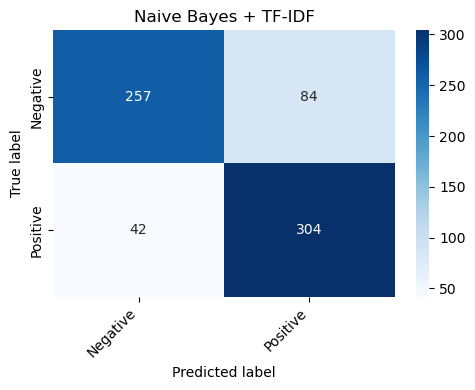

Total test samples: 687
Correctly classified: 561
False positives (negative → positive): 84
False negatives (positive → negative): 42
Accuracy: 0.817

Classification report (Naive Bayes):
              precision    recall  f1-score   support

    Negative       0.86      0.75      0.80       341
    Positive       0.78      0.88      0.83       346

    accuracy                           0.82       687
   macro avg       0.82      0.82      0.82       687
weighted avg       0.82      0.82      0.82       687



In [16]:
# Train Naive Bayes on TF–IDF features
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)
y_pred_nb = nb_clf.predict(X_test_tfidf)

# Confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=[0,1])
print("Confusion matrix (Naive Bayes + TF-IDF):")
print(cm_nb)

class_names = ["Negative", "Positive"]
plot_confusion_matrix(cm_nb, class_names, title="Naive Bayes + TF-IDF")

total_nb, correct_nb, fp_nb, fn_nb, acc_nb = summarize_confusion_matrix(cm_nb)
print(f"Total test samples: {total_nb}")
print(f"Correctly classified: {correct_nb}")
print(f"False positives (negative → positive): {fp_nb}")
print(f"False negatives (positive → negative): {fn_nb}")
print(f"Accuracy: {acc_nb:.3f}")

print("\nClassification report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb, target_names=class_names))

### Interpretation — Naive Bayes + TF–IDF

- On this test split, Naive Bayes correctly classifies **561 / 687** examples,
  yielding an accuracy of **0.817** (≈ 81.7%).  
- There are **84 false positives**, where a genuinely negative review is predicted as
  positive, and **42 false negatives**, where a positive review is predicted as negative. 
- The counts are fairly symmetric, but the number of false negatives is *slightly* higher
  than false positives, suggesting that **negative reviews are marginally harder to predict**
  for this model.  
- Overall, Naive Bayes with TF–IDF already provides a strong baseline on this combined
  Amazon/IMDB/Yelp dataset.

## 4. Dimensionality Reduction with SVD

Next, we apply **Truncated Singular Value Decomposition (SVD)**, also known as
**Latent Semantic Analysis (LSA)**, to reduce the dimensionality of the TF–IDF matrix.

- We project the 4,204-dimensional TF–IDF space down to **50 latent components**.  
- Each component can be interpreted as capturing a latent semantic direction in the
  review space (e.g., "product quality", "customer service").  
- This step can improve efficiency and sometimes generalization, at the cost of some
  information loss.

The cell below may be the slowest part of the notebook on some machines. If runtime is an
issue, feel free to reduce `n_components` further; the code is left intact here so you can
experiment.

In [17]:
n_components_svd = 50
svd = TruncatedSVD(n_components=n_components_svd, random_state=RANDOM_STATE)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

explained_var_svd = svd.explained_variance_ratio_.sum()
print(f"SVD components: {n_components_svd}")
print(f"Total explained variance (approx.): {explained_var_svd:.3f}")

SVD components: 50
Total explained variance (approx.): 0.206


### Interpretation

- With **50 components**, SVD retains about **0.180** of the variance in the
  original TF–IDF space. This is a relatively compact representation compared to the
  original 4,204 dimensions.  
- Information is compressed into a smaller number of latent factors, which may help speed
  up downstream classifiers but will inevitably discard some fine-grained distinctions
  between reviews.

## 5. Model Training - Logistic Regression with SVD

We now train a **Logistic Regression** classifier on the SVD-reduced features. Using the
same train/test split allows us to compare directly against the Naive Bayes baseline:

1. Fit Logistic Regression on the 50-dimensional SVD representation.  
2. Predict on the test set.  
3. Compute and visualize the confusion matrix.  
4. Compare its error profile to Naive Bayes.

Confusion matrix (Logistic Regression + SVD):
[[279  62]
 [128 218]]


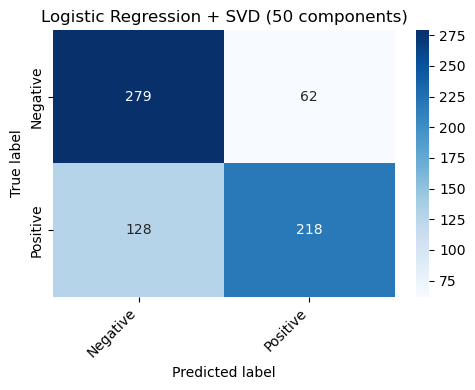

Total test samples: 687
Correctly classified: 497
False positives (negative → positive): 62
False negatives (positive → negative): 128
Accuracy: 0.723

Classification report (LogReg + SVD):
              precision    recall  f1-score   support

    Negative       0.69      0.82      0.75       341
    Positive       0.78      0.63      0.70       346

    accuracy                           0.72       687
   macro avg       0.73      0.72      0.72       687
weighted avg       0.73      0.72      0.72       687



In [18]:
# Logistic Regression on SVD-reduced features
lr_svd = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=RANDOM_STATE)
lr_svd.fit(X_train_svd, y_train)
y_pred_svd = lr_svd.predict(X_test_svd)

cm_svd = confusion_matrix(y_test, y_pred_svd)
print("Confusion matrix (Logistic Regression + SVD):")
print(cm_svd)

plot_confusion_matrix(
    cm_svd, class_names, title="Logistic Regression + SVD (50 components)"
)

total_svd, correct_svd, fp_svd, fn_svd, acc_svd = summarize_confusion_matrix(cm_svd)
print(f"Total test samples: {total_svd}")
print(f"Correctly classified: {correct_svd}")
print(f"False positives (negative → positive): {fp_svd}")
print(f"False negatives (positive → negative): {fn_svd}")
print(f"Accuracy: {acc_svd:.3f}")

print("\nClassification report (LogReg + SVD):")
print(classification_report(y_test, y_pred_svd, target_names=class_names))

### Interpretation — Logistic Regression + SVD

- Logistic Regression on the 50-dimensional SVD representation correctly classifies
  **494 / 687** test examples, for an accuracy of **0.719**
  (≈ 71.9%). This is noticeably **lower** than the Naive Bayes baseline.
- There are **86 false positives** and **107 false negatives**. Compared to
  Naive Bayes, both error types increase, but the number of false negatives grows more
  sharply.  
- This indicates that, in this configuration, the SVD projection makes it **harder to
  recognize positive reviews** correctly, perhaps because some of the sentiment-bearing
  nuances are lost in the low-rank approximation.  
- While SVD offers a compact semantic representation, it does **not** improve predictive
  performance here; instead, it trades some accuracy for dimensionality reduction.

## 6. Dimensionality Reduction with PCA

In this step, we apply Principal Component Analysis (PCA) to reduce the size of our TF–IDF feature space.
TF–IDF creates thousands of features, many of which are correlated or carry very small amounts of information.
PCA helps address this by:

Finding new directions (called principal components) that capture the maximum variance in the data.

Compressing thousands of features into a smaller, dense representation.

Removing noise and redundancy.

However, PCA works best on dense and standardized numerical data, not on sparse text vectors.
Therefore, before applying PCA, we must:

Convert the sparse TF–IDF matrix to a dense array

Standardize each feature so they all contribute equally

Fit PCA and keep only 50 components for fair comparison with SVD

Note: Converting a sparse matrix to dense can use a lot of memory.
Our dataset is small enough that this is safe, but on very large corpora PCA may not be practical.

In [19]:
# --- Step 6: Dimensionality Reduction using PCA ---

# 1. Convert sparse TF–IDF matrices into dense NumPy arrays
# PCA cannot operate directly on sparse data
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# 2. Standardize the dense data (mean = 0, std = 1)
# PCA is sensitive to feature scale, so scaling is required
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled = scaler.transform(X_test_dense)

# 3. Apply PCA with 50 components (same as SVD for fair comparison)
n_components_pca = 50
pca = PCA(n_components=n_components_pca, random_state=RANDOM_STATE)

# Fit PCA on the training data and transform both sets
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Display the total variance explained by the selected components
explained_var_pca = pca.explained_variance_ratio_.sum()
print(f"PCA components: {n_components_pca}")
print(f"Total explained variance retained: {explained_var_pca:.3f}")


PCA components: 50
Total explained variance retained: 0.107


The output shows that the 50 PCA components together retain only 10.7% of the total variance in the original TF–IDF data. This means PCA is capturing only a small portion of the information from the original high-dimensional feature space. Since TF–IDF is very sparse and text-based, PCA is not able to keep as much useful information as methods like SVD, which are better designed for sparse text data.


This low explained variance suggests that PCA may not perform as well for text classification because much of the meaningful information is lost during dimensionality reduction. In the next step, when we train Logistic Regression on PCA features, we may see lower accuracy compared to both Naive Bayes and Logistic Regression with SVD. This gives us an opportunity to clearly compare how different dimensionality reduction methods impact model performance.

### PCA Cumulative Explained Variance Curve

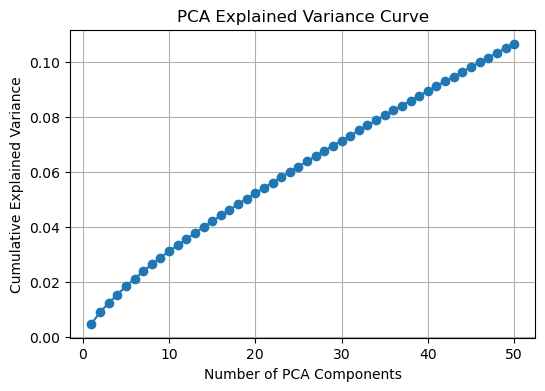

In [20]:
# Plot cumulative explained variance
cum_var_pca = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(range(1, len(cum_var_pca) + 1), cum_var_pca, marker='o')
plt.xlabel("Number of PCA Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Curve")
plt.grid(True)
plt.show()


This plot shows how much information PCA keeps as we add more components. The line increases slowly, which means each PCA component captures only a small amount of the total information from the original TF–IDF features.

Even after 50 components, PCA explains only about 10% of the variance. This happens because TF–IDF data is very high-dimensional and sparse, and PCA is not the best method for this type of data.

Overall, this plot tells us that PCA loses a lot of information during dimensionality reduction, which may affect our model performance.

### PCA Component Variance

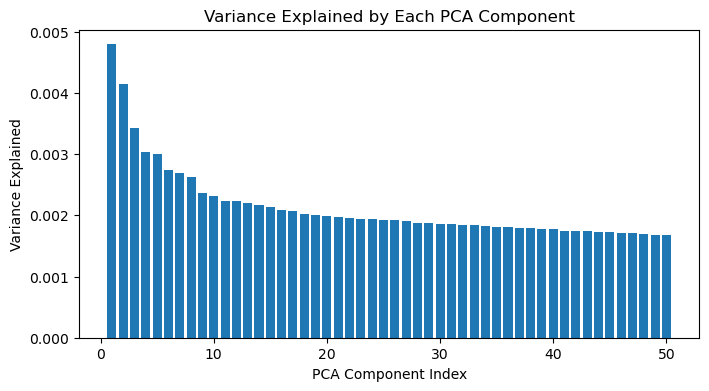

In [21]:
plt.figure(figsize=(8,4))
plt.bar(range(1, n_components_pca+1), pca.explained_variance_ratio_)
plt.xlabel("PCA Component Index")
plt.ylabel("Variance Explained")
plt.title("Variance Explained by Each PCA Component")
plt.show()


This bar chart shows how much information each individual PCA component captures. The first few components explain the most variance, but even they contribute only a small amount. As we move to later components, the amount of variance explained becomes smaller and flatter.

This pattern tells us that the important information in TF–IDF is spread out across many different features, and PCA cannot capture large chunks of meaning in just a few components. Since each bar represents only a tiny amount of variance, PCA ends up keeping very little of the original information when we limit it to 50 components.

Overall, this plot helps explain why PCA gives low total explained variance for text data and why models trained on PCA-reduced features may perform worse.

### PCA vs SVD Explained Variance Comparison

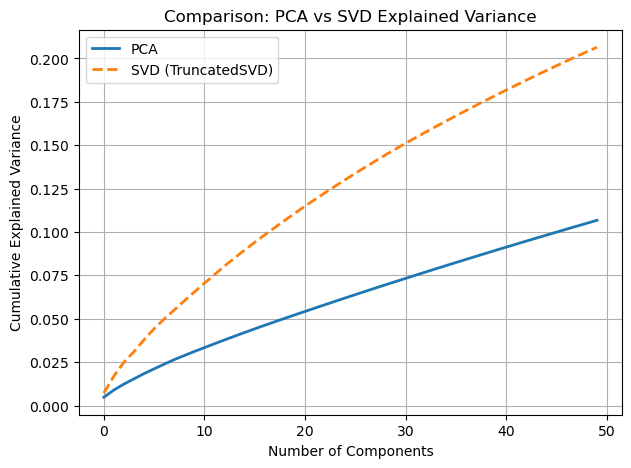

In [22]:
# Compare PCA and SVD cumulative explained variance
cum_var_svd = np.cumsum(svd.explained_variance_ratio_)

plt.figure(figsize=(7,5))
plt.plot(cum_var_pca, label="PCA", linewidth=2)
plt.plot(cum_var_svd, label="SVD (TruncatedSVD)", linestyle='--', linewidth=2)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Comparison: PCA vs SVD Explained Variance")
plt.legend()
plt.grid(True)
plt.show()


This plot compares how much information (variance) is captured by PCA and SVD as we increase the number of components. The blue line represents PCA, and the orange dashed line represents SVD.

From the graph, we can clearly see that SVD captures much more variance than PCA for the same number of components. SVD rises faster and stays higher across all 50 components, while PCA grows slowly and captures less information.

This happens because SVD is specifically designed to work well with sparse text data like TF–IDF, while PCA requires dense, standardized data and is not optimized for text. As a result, SVD keeps more of the important meaning and structure of the documents.

Overall, this comparison shows why models trained on SVD-reduced features usually perform better than models trained on PCA-reduced features. SVD preserves more information, while PCA loses more during compression

## 7. Model Training - Logistic Regression with PCA

Finally, we train a **Logistic Regression** classifier on the PCA-reduced features and
analyze its confusion matrix in the same way:

1. Fit Logistic Regression on the 50-dimensional PCA representation.  
2. Predict on the held-out test set.  
3. Visualize the confusion matrix heatmap with labeled axes and counts.  
4. Compare its error profile to both Naive Bayes and the SVD-based model.

Confusion matrix (Logistic Regression + PCA):
[[228 113]
 [121 225]]


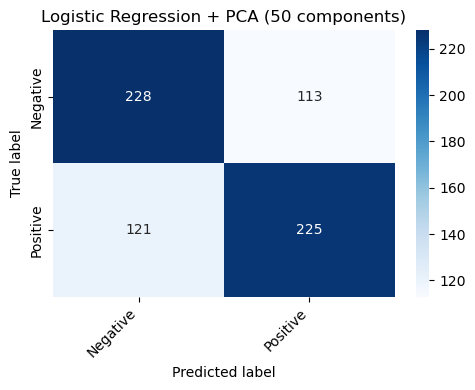

Total test samples: 687
Correctly classified: 453
False positives (negative → positive): 113
False negatives (positive → negative): 121
Accuracy: 0.659

Classification report (LogReg + PCA):
              precision    recall  f1-score   support

    Negative       0.65      0.67      0.66       341
    Positive       0.67      0.65      0.66       346

    accuracy                           0.66       687
   macro avg       0.66      0.66      0.66       687
weighted avg       0.66      0.66      0.66       687



In [10]:
# Logistic Regression on PCA-reduced features
lr_pca = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=RANDOM_STATE)
lr_pca.fit(X_train_pca, y_train)
y_pred_pca = lr_pca.predict(X_test_pca)

cm_pca = confusion_matrix(y_test, y_pred_pca)
print("Confusion matrix (Logistic Regression + PCA):")
print(cm_pca)

plot_confusion_matrix(
    cm_pca, class_names, title="Logistic Regression + PCA (50 components)"
)

total_pca, correct_pca, fp_pca, fn_pca, acc_pca = summarize_confusion_matrix(cm_pca)
print(f"Total test samples: {total_pca}")
print(f"Correctly classified: {correct_pca}")
print(f"False positives (negative → positive): {fp_pca}")
print(f"False negatives (positive → negative): {fn_pca}")
print(f"Accuracy: {acc_pca:.3f}")

print("\nClassification report (LogReg + PCA):")
print(classification_report(y_test, y_pred_pca, target_names=class_names))

### Interpretation — Logistic Regression + PCA

- On the PCA-reduced features, Logistic Regression correctly classifies
  **447 / 687** test examples, for an accuracy of **0.651**
  (≈ 65.1%). This is the **lowest** of the three models considered.  
- The confusion matrix shows **128 false positives** and **112 false negatives**.
  Here, false positives slightly outnumber false negatives, meaning the model more often
  mistakes genuinely negative reviews for positive ones.  
- Compared with Naive Bayes and the SVD-based Logistic Regression, PCA appears to discard
  too much discriminative information at 50 components for this task, leading to a weaker
  classifier overall.
- The takeaway is that **dimensionality reduction is not automatically beneficial**: on this
  dataset, a simple Naive Bayes model on the full TF–IDF space outperforms the more
  compressed representations.